### Entity Recognition

#### To read and classify text into pre-defined categories as a means of information extraction.

In [14]:
# importing necessary libraries and dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn_crfsuite import CRF, scorers, metrics
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.metrics import classification_report, make_scorer
import scipy.stats
%matplotlib inline

In [15]:
# # reading in the training data

# f = open("train.txt", "r")
# print(f.read())

### Exploratory Data Analysis

At first glance, the data looks like a collection of messages or tweets with @ tags and hastags. Each message consists of 1 or more sentence and each sentence is a collection of words. Each word from the message is labeled in the training set according to it's classification tag.

Let's push the data into a dataframe so it's easier for EDA.

In [16]:
# # reading in text line-by-line converting each string to a list
# f = open("train.txt", "r")
# for x in f:
#     print(x[:-1].split("\t"))

In [17]:
# function to create a dataframe with columns 'message', 'word' and 'label'
def text_to_df(filename):
    df = pd.DataFrame(columns=['message', 'word', 'label'])
    i = 1
    f = open(filename, "r")
    for x in f:
        tmp_list = x[:-1].split("\t")
        try:
            tmp_dict = {'message': i,'word': tmp_list[0], 'label': tmp_list[1]}
            if tmp_list[0] == '':
                i = i+1
            else:
                df = df.append(tmp_dict, ignore_index=True)
                #print(tmp_dict)
        except:
            i = i+1
    return df

In [18]:
# creating a dataframe
dfObj = text_to_df("train.txt")

In [19]:
# examining the dataframe
print(dfObj.head())
print("\nthe total number of messages are: ", dfObj.iloc[[ -1]].message)
print("the total number of words are: ", len(dfObj.word))
print("the total number of unique words are: ", len(np.unique(dfObj.word)))
print("the total number of unique labels: ", len(np.unique(dfObj.label)))
      
# looking at all the unique labels
unique_labels = np.unique(dfObj.label)
print('\nunique labels: ',unique_labels)

  message       word label
0       1  @paulwalk     O
1       1         It     O
2       1         's     O
3       1        the     O
4       1       view     O

the total number of messages are:  62729    3394
Name: message, dtype: object
the total number of words are:  62730
the total number of unique words are:  14878
the total number of unique labels:  13

unique labels:  ['B-corporation' 'B-creative-work' 'B-group' 'B-location' 'B-person'
 'B-product' 'I-corporation' 'I-creative-work' 'I-group' 'I-location'
 'I-person' 'I-product' 'O']


In [20]:
# lets look at the kind of words present under each label to understand these categories better
for l in unique_labels:
    print("\nwords under ", l, "\n")
    print(dfObj[dfObj.label==l][:5])


words under  B-corporation 

     message      word          label
42         3   Pxleyes  B-corporation
249       16  facebook  B-corporation
320       22  MetroPCS  B-corporation
649       38   Ustream  B-corporation
1019      56  facebook  B-corporation

words under  B-creative-work 

    message                  word            label
77        6                   VMA  B-creative-work
660      39                Winter  B-creative-work
804      46  #BattlestarGalactica  B-creative-work
816      46             #StarWars  B-creative-work
912      50                iCarly  B-creative-work

words under  B-group 

     message     word    label
31         2     AHFA  B-group
504       32   ravens  B-group
1760      91    Three  B-group
1822      95  #Padres  B-group
2123     110  Natives  B-group

words under  B-location 

    message       word       label
14        1     Empire  B-location
18        1        ESB  B-location
601      36  Wisconsin  B-location
781      45       S.F.  B-l

#### Inferences

- `B/I-corporation` includes companies and corporations.
- `B/I-creative-work` seems vague and includes a mixture of some franchising ideas, TV show names and people names.
- `B/I-group` seems to include clans, teams, groups of people and collective nouns.
- `B/I-location` includes places to visit, countries, states and regions 
- `B/I-person` mostly includes names of people.
- `B/I-product` represents names of products, brands and commodities.
- `O` represents all other words which do not fall into any of these categories, including punctuation.

#### Key Insights 

1. At this point, it is hard to find a marked difference between the `B-` and `I-` prefix by merely examining words.
2. Most words under `B/I-corporation`, `B/I-person` and `B/I-product` are proper nouns (name, place, thing) and start with a capital letter.
3. There are some numbers present under each of these labels. For instance '107' under `I-corporation`; 5800 and 360 under `I-product` and 3 under `I-creative-work` (we'll look at this in more detail).
4. Most hashtags are present under the `B/I-creative-work` tag which might be an important feature for classification. Hence, I don't plan to remove it at this stage.
5. The same goes for the symbol @. Most instances of this symbol are before a coportation or person when they are tagged in a message/ tweet. Let's keep it that way.

Coming back to point 3, let's take a look into the messages in which these numbers show up.

In [21]:
dfObj[dfObj.message==346]

,message,word,label
6656,346,We,O
6657,346,are,O
6658,346,tied,O
6659,346,as,O
6660,346,the,O
6661,346,5th,O
6662,346,band,O
6663,346,to,O
6664,346,compete,O
6665,346,in,O


In [22]:
dfObj[dfObj.message==122]

,message,word,label
2340,122,Toy,B-creative-work
2341,122,story,I-creative-work
2342,122,3,I-creative-work
2343,122,tonight,O
2344,122,on,O
2345,122,the,O
2346,122,lawn,O
2347,122,!,O


In [23]:
dfObj[dfObj.message==679]

,message,word,label
13174,679,http://bit.ly/aTTQYq,O
13175,679,When,O
13176,679,Pepsi,B-corporation
13177,679,to,O
13178,679,ring,O
13179,679,usually,O
13180,679,confirm,O
13181,679,to,O
13182,679,",",O
13183,679,winning,O


#### More Insights

- By examining the placement of these words in the message context, I would think that `-B` and `-I` stand for beginning and intermediate, respectively. The first instance of occurance of any of the categories would be tagged with a `-B` and the second (and onward) would be tagged with an `-I`. 

- Additionally, the labels on the numbers do make sense since 'Nokia 5800' is the name of a mobile phone and 'Toy Story 3' is a copyrighted movie title. So let's keep them in place.

- Furthermore, we can gather that the previously less understood class 'creative-work' contains content tied to intellectual property, copyrighted names and patents.

In [24]:
# lets look at the distribution of these labels
print("Frequency of label occurance:\n")
for label in np.unique(dfObj.label):
    print(label+':', list(dfObj.label).count(label))

Frequency of label occurance:

B-corporation: 221
B-creative-work: 140
B-group: 264
B-location: 548
B-person: 660
B-product: 142
I-corporation: 46
I-creative-work: 206
I-group: 150
I-location: 245
I-person: 335
I-product: 203
O: 59570


`O` seems to have a large number of words compared to all the other classes, which is understandable. Let's look at these statistics visually without `O`.

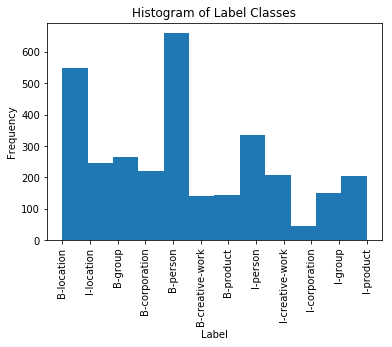

In [25]:
# creating histograms

new_df = dfObj[dfObj.label!='O']
list_of_labels = list(new_df.label)
plt.hist(list_of_labels, bins = 12)
plt.xticks(rotation='vertical')
plt.title('Histogram of Label Classes')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

B-person seems to have the highest number of tagged words (about 660) while the average tagged words per catergory is about 200. On the other hand, I-corporation has the lowest number of tagged words (about 46). We could consider removing this class later to improve on the model prediction, if need be.

In [26]:
# lets define a class Message with the following fields and methods
class Message(object):
    def __init__(self, data):
        self.data = data
        zipper = lambda s: [(w, t) for w, t in zip(list(s["word"].values),list(s["label"].values))]
        self.grouped = self.data.groupby("message").apply(zipper)
        self.messages = [s for s in self.grouped]

In [27]:
# creating an instance of class Message
message_obj = Message(dfObj)

In [28]:
# what's the longest message?
messages = message_obj.messages
largest_message = max(len(m) for m in messages)
print('the longest message has {} words'.format(largest_message))

the longest message has 41 words


In [29]:
# messages

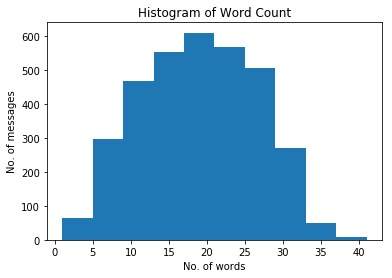

In [30]:
# lets look at the distribution of words in the messages
plt.hist([len(m) for m in messages])
plt.title('Histogram of Word Count')
plt.xlabel('No. of words')
plt.ylabel('No. of messages')
plt.show()

The longest message is 41 words long and the histogram shows an almost normal distribution with most messages having about 20-25 words. The average tweet word count is about 28 and since we have an average between 20-25 words, it's likely that we're examining a dataset of tweets.

### Performance metrics

Choosing the right performance metrics often depends on the problem being solved. The results from classification are _actual values_ vs. _predicted values_ which can be understood in terms of _true positives, true negatives, false positives_ and _false negatives_. 

In the case of entity recognition, literature suggests that __F1 score__, __Precision__ and __Recall__ are the most widely used performance metrics which are based on true/false positives/negatives.

- Precision = TP/TP+FP = correctly predicted positive observations/ total predicted positive observations. 
- Recall = TP/TP+FN = correctly predicted positive observations/ all observations in actual class. 
- F1 Score = 2(Recall)(Precision)/ Recall+Precision (takes both _false positives_ and _false negatives_ into account).

Note that high precision and recall is preferred for a good classifier and we evaluate the model using these metrics per class to make sure we have a good model.

### Training the model

Now that we have a fairly good idea about the dataset, let's start with a simpler approch to modeling, a `RandomForestClassifier`. We'll then build on the complexity depending on the results we get.

Here are some reasons why using a `RandomForestClassifier` is indeed a good idea:

- Based on the vast amount of literature avaiable, random forest classifiers seem to be accurate for applications like information extraction.
- These classifiers are able to automatically construct correlation paths from the feature space.

__Method 1: Random Forest Classifier__

In [31]:
# separating features and labels to feed into the classifier

#function to convert words to a features array to feed into the classifier.
def extract_features_rf(word):
    features = np.array([word.istitle(), 
                         word.islower(), 
                         word.isupper(), 
                         len(word), 
                         word.isdigit(),  
                         word.isalpha()])
    return features

features = []
for w in dfObj["word"].values.tolist():
    features.append(extract_features_rf(w))
    
labels = list(dfObj["label"].values)

#let's take a look at what we have now
print("Labels: ", labels[:10])
print("Features: ", features[:10])

Labels:  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Features:  [array([0, 1, 0, 9, 0, 0]), array([1, 0, 0, 2, 0, 1]), array([0, 1, 0, 2, 0, 0]), array([0, 1, 0, 3, 0, 1]), array([0, 1, 0, 4, 0, 1]), array([0, 1, 0, 4, 0, 1]), array([0, 1, 0, 5, 0, 1]), array([1, 0, 1, 1, 0, 1]), array([0, 1, 0, 2, 0, 0]), array([0, 1, 0, 6, 0, 1])]


In [32]:
# creating a random forest Classifier
clf = RandomForestClassifier(n_estimators=100)

# applying five fold cross validation
pred = cross_val_predict(clf,X=features, y=labels, cv=5)

Here, the data set is split into 5 folds. In the first iteration, the first fold is used to test the model and the rest are used to train the model. In the second iteration, 2nd fold is used as the testing set while the rest serve as the training set. This process is repeated until each fold of the 5 folds have been used as the testing set. `n_estimators` is the number of trees in the forest.

In [33]:
# let's look at the predicitons
z = tuple(zip(pred, labels))
print(z[:20])

(('O', 'O'), ('O', 'O'), ('O', 'O'), ('O', 'O'), ('O', 'O'), ('O', 'O'), ('O', 'O'), ('O', 'O'), ('O', 'O'), ('O', 'O'), ('O', 'O'), ('O', 'O'), ('O', 'O'), ('O', 'O'), ('O', 'B-location'), ('O', 'I-location'), ('O', 'I-location'), ('O', 'O'), ('O', 'B-location'), ('O', 'O'))


There seem to be quite a lot of incorrect predictions

In [34]:
# lets check the model performance report
from sklearn.metrics import classification_report

clf_report = classification_report(y_pred=pred, y_true=labels)
print(clf_report)

/Users/srutidammalapati/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                 precision    recall  f1-score   support

  B-corporation       0.29      0.03      0.06       221
B-creative-work       0.25      0.01      0.01       140
        B-group       0.00      0.00      0.00       264
     B-location       0.12      0.00      0.00       548
       B-person       0.00      0.00      0.00       660
      B-product       0.00      0.00      0.00       142
  I-corporation       0.00      0.00      0.00        46
I-creative-work       0.00      0.00      0.00       206
        I-group       0.00      0.00      0.00       150
     I-location       0.00      0.00      0.00       245
       I-person       0.00      0.00      0.00       335
      I-product       0.00      0.00      0.00       203
              O       0.95      1.00      0.97     59570

       accuracy                           0.95     62730
      macro avg       0.12      0.08      0.08     62730
   weighted avg       0.90      0.95      0.93     62730



#### Hyperparameter Tuning

Hyperparameter tuning is important to find the ideal model settings for our dataset which can improve the model. `GridSearchCV` and `RandomizedSearchCV` are both popular methods for hyperparameter tuning.

Let's use` GridSearchCV` to optimize hyperparameters to check whether there is any scope for improvement with a `RandomForestClassifier`.

In [35]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [80, 90, 100, 110],
    'n_estimators': [200, 100, 50, 20]
}

# creating a random forest classifier model
clf = RandomForestClassifier()

# instantiating the grid search model
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2)

In [36]:
# fitting the grid search to the data

grid_search.fit(features, labels)
grid_search.best_params_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.0min finished


{'max_depth': 110, 'n_estimators': 20}

In [37]:
grid_search.best_score_

0.9493703172325841

In [38]:
pred = cross_val_predict(RandomForestClassifier(n_estimators=200,max_depth=80),X=features, y=labels, cv=5)

clf_report = classification_report(y_pred=pred, y_true=labels)
print(clf_report)

/Users/srutidammalapati/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                 precision    recall  f1-score   support

  B-corporation       0.32      0.03      0.06       221
B-creative-work       0.00      0.00      0.00       140
        B-group       0.00      0.00      0.00       264
     B-location       0.12      0.00      0.00       548
       B-person       0.00      0.00      0.00       660
      B-product       0.00      0.00      0.00       142
  I-corporation       0.00      0.00      0.00        46
I-creative-work       0.00      0.00      0.00       206
        I-group       0.00      0.00      0.00       150
     I-location       0.00      0.00      0.00       245
       I-person       0.00      0.00      0.00       335
      I-product       0.00      0.00      0.00       203
              O       0.95      1.00      0.97     59570

       accuracy                           0.95     62730
      macro avg       0.11      0.08      0.08     62730
   weighted avg       0.90      0.95      0.93     62730



- The _precision, recall_ and _F1 score_ values for most categories are 0, which means that the model is not performing well even on the training dataset. The `RandomForestClassifier` trains the model on words without accounting for it's placement in the sentence. In entity recognition, since the context of the words in the sentence must be recognized by the model we would have to account for this in some manner. We noticed this while performing EDA, where '5800' was tagged as an `I-product` since it's preceeding word is Nokia and 'Nokia 5800' is a product name. 

- Thus, to improve the accuracy of our model, we would have to add this layer of complexity that takes into account the neighouring words. We try using a Conditional Random Field or `CRF` Classifier which has better accuracy over a `RandomForestClassifier`.

__Method 2: Conditional Random Field__

CRFs are discriminative models best suited for prediction tasks where contextual information or state of the neighbors affect the current prediction.The structure of CRFs make them ideal for tasks that capture sequential relations like POS tagging a sentence, named entity recognition etc. An optimizer like `lbfgs` works well for CRFs which is what we'll use here ([see reference](https://towardsdatascience.com/conditional-random-fields-explained-e5b8256da776)).

In [39]:
# function for feature extraction
# m is each message from the list of 'messages', which is a list of tuples
# i is the index number of the word-label tuple for each message
    
def extract_features(m, i):
    
    # extracting the word from a tuple m[i]
    word = m[i][0]
    
    # creating a features dictonary for quick lookup
    features = {
        'lowercase': word.lower(),
        'last_3': word[-3:],
        'last_2': word[-2:],
        'uppercase': word.isupper(),
        'titlecase': word.istitle(),
        'digit': word.isdigit(),
    }
    
    # the features dictonary is updated to include features of words present before and after the given word
    # this allows the model to remember the context in which a word appears
    
    if i > 0:
        # not the first word, so...
        word_before = m[i-1][0]
        features.update({
            '-1:lowercase': word_before.lower(),
            '-1:titlecase': word_before.istitle(),
            '-1:uppercase': word_before.isupper(),
        })
    else:
        # the word must be the first word in the message
        features['first word'] = True

    if i < len(m)-1:
        # not the last word, so...
        word_after = m[i+1][0]
        features.update({
            '+1:lowercase': word_after.lower(),
            '+1:titlecase': word_after.istitle(),
            '+1:uppercase': word_after.isupper(),
        })
    else:
        # the word must be at the end of the message
        features['last word'] = True

    return features

In [40]:
# splitting into features and labels
def get_features_labels(messages):
    features = []
    labels = []
    for m in messages:

        # for the features part
        f = [extract_features(m, i) for i in range(len(m))]
        features.append(f)

        # for the labels part
        l = [label for token, label in m]
        labels.append(l)
    return [features, labels]

In [41]:
features = get_features_labels(messages)[0]
labels = get_features_labels(messages)[1]

In [42]:
# features

In [43]:
# creating the CRF model
crf = CRF(algorithm='lbfgs', c1=0.1, c2=0.1, max_iterations=100, all_possible_transitions=False)

In [44]:
# predciting using 5 fold cross validation just as before
pred = cross_val_predict(estimator=crf, X=features, y=labels, cv=5)

In [45]:
# let's evaluate the model now
report = flat_classification_report(y_pred=pred, y_true=labels)
print(report)

                 precision    recall  f1-score   support

  B-corporation       0.83      0.34      0.49       221
B-creative-work       0.40      0.17      0.24       140
        B-group       0.52      0.12      0.20       264
     B-location       0.73      0.40      0.52       548
       B-person       0.69      0.33      0.45       660
      B-product       0.91      0.15      0.25       142
  I-corporation       0.33      0.09      0.14        46
I-creative-work       0.40      0.25      0.31       206
        I-group       0.47      0.11      0.17       150
     I-location       0.60      0.33      0.43       245
       I-person       0.71      0.41      0.52       335
      I-product       0.85      0.14      0.24       203
              O       0.97      1.00      0.98     59570

       accuracy                           0.96     62730
      macro avg       0.65      0.30      0.38     62730
   weighted avg       0.95      0.96      0.95     62730



The model seems to be doing much better than when we previously used a `RandomForestClassifier` although, it can be improved. Let's try our luck with _hyperparameter optimization_ to bring improvement to our classifier.

#### Hyperparameter Tuning

`RandomizedSearchCV` sets up a grid of hyperparameter values and selects random combinations to train the model and score which makes it faster than `GridSearchCV`.

In [46]:
# creating hyperparameter dictonary or parameters grid
crf = CRF(algorithm='lbfgs', max_iterations=100, all_possible_transitions=False)

hyperparameters = {'c1': scipy.stats.expon(scale=0.5),'c2': scipy.stats.expon(scale=0.05)}

# instantiating the randomized search model
random_grid = RandomizedSearchCV(crf, hyperparameters, n_iter=50, cv=5, verbose=0, n_jobs=-1)
random_grid.fit(features, labels)

/Users/srutidammalapati/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=CRF(algorithm='lbfgs', all_possible_states=None,
                                 all_possible_transitions=False, averaging=None,
                                 c=None, c1=None, c2=None,
                                 calibration_candidates=None,
                                 calibration_eta=None,
                                 calibration_max_trials=None,
                                 calibration_rate=None,
                                 calibration_samples=None, delta=None,
                                 epsilon=None, error_sensitive=None...
                                 num_memories=None, pa_type=None, period=None,
                                 trainer_cls=None, variance=None,
                                 verbose=False),
                   iid='warn', n_iter=50, n_jobs=-1,
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_frozen object at

In [47]:
# lets check the best estimated parameters and CV score
print('Best parameters:', random_grid.best_params_)
print('Best CV score:', random_grid.best_score_)

Best parameters: {'c1': 0.20807138743308443, 'c2': 0.02197719511269827}
Best CV score: 0.9605980519904453


In [48]:
# # now we create the model again using the best estimators
# crf_best = random_grid.best_estimator_
# y_pred = cross_val_predict(estimator=crf_best, X=features, y=labels, cv=10)
# print(metrics.flat_classification_report(labels, y_pred, digits=3))

In [49]:
crf_best = random_grid.best_estimator_
y_pred = crf_best.predict(features)
print(metrics.flat_classification_report(labels, y_pred, digits=3))

                 precision    recall  f1-score   support

  B-corporation      0.991     0.977     0.984       221
B-creative-work      0.985     0.964     0.975       140
        B-group      0.989     0.996     0.992       264
     B-location      0.994     0.987     0.991       548
       B-person      0.997     0.991     0.994       660
      B-product      1.000     0.979     0.989       142
  I-corporation      0.978     0.978     0.978        46
I-creative-work      1.000     0.971     0.985       206
        I-group      0.993     0.993     0.993       150
     I-location      1.000     0.988     0.994       245
       I-person      1.000     0.994     0.997       335
      I-product      0.995     1.000     0.998       203
              O      0.999     1.000     1.000     59570

       accuracy                          0.999     62730
      macro avg      0.994     0.986     0.990     62730
   weighted avg      0.999     0.999     0.999     62730



__Testing on the test dataset__

In [50]:
test_obj = Message(data)
test_messages = test_obj.messages

test_features = get_features_labels(test_messages)[0]
test_labels = get_features_labels(test_messages)[1]

y_pred = crf_best.predict(test_features)

In [51]:
newdf = []
for i,message in enumerate(test_messages):
    for j,words in enumerate(message):
        words[1]
        newdf.append((words[0],y_pred[i][j]))
# newdf

The CRF model does not seem to be doing too well for all classes. The model is not able to tag a lot of the named entities.


Generally speaking, CRF models are capable enough to capture features of the current and previous labels in a sequence. However, a challenge with these models is that they cannot understand the context of forward labels. Using CRFs also involve additional feature extraction steps as defined in `extract_features`. 

That being said, another approach for entity recognition applications is bidirectional-LSTMs, which we'll look into next. 

__Method 3: Long Short-Term Memory__


Standard LSTMs can only account for the “past” information in a text sequence which do not make them a very attractive choice for entity recognition. However, bidirectional-LSTMs account for "past" and "future" labels in a sequence. 

LSTM requires that the messages be of similar lengths. For this reason, we pad those messages which have words < maximum message length by including the word `'padding'` in them.

In [52]:
# function to pad messages
def pad_messages(messages):
    max_len = 41
    #padding all messages to length of max_len 
    x = [[word[0]for word in m] for m in messages]
    x_padded = []
    for s in x:
        s_padded = []
        for i in range(max_len):
            try:
                s_padded.append(s[i])
            except:
                s_padded.append("padding")
        x_padded.append(s_padded)
    return x_padded

In [53]:
# calling the pad message function
x_padded = pad_messages(messages)

# looking at the first five after padding
x_padded[:2]

[['@paulwalk',
  'It',
  "'s",
  'the',
  'view',
  'from',
  'where',
  'I',
  "'m",
  'living',
  'for',
  'two',
  'weeks',
  '.',
  'Empire',
  'State',
  'Building',
  '=',
  'ESB',
  '.',
  'Pretty',
  'bad',
  'storm',
  'here',
  'last',
  'evening',
  '.',
  'padding',
  'padding',
  'padding',
  'padding',
  'padding',
  'padding',
  'padding',
  'padding',
  'padding',
  'padding',
  'padding',
  'padding',
  'padding',
  'padding'],
 ['From',
  'Green',
  'Newsfeed',
  ':',
  'AHFA',
  'extends',
  'deadline',
  'for',
  'Sage',
  'Award',
  'to',
  'Nov',
  '.',
  '5',
  'http://tinyurl.com/24agj38',
  'padding',
  'padding',
  'padding',
  'padding',
  'padding',
  'padding',
  'padding',
  'padding',
  'padding',
  'padding',
  'padding',
  'padding',
  'padding',
  'padding',
  'padding',
  'padding',
  'padding',
  'padding',
  'padding',
  'padding',
  'padding',
  'padding',
  'padding',
  'padding',
  'padding',
  'padding']]

In [271]:
from keras.preprocessing.sequence import pad_sequences

# creating a function to encode text labels into numbers for the classifier to understand
def encode_labels(unique_labels, messages):
    encoded_labels = {label:i for i,label in enumerate(unique_labels)}
    print(encoded_labels)
    y = [[encoded_labels[w[1]] for w in s] for s in messages]
    #encoding padded words to label 'O'
    y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=encoded_labels["O"])
    return y

In [272]:
y = encode_labels(unique_labels, messages)
y[:5]

{'B-corporation': 0, 'B-creative-work': 1, 'B-group': 2, 'B-location': 3, 'B-person': 4, 'B-product': 5, 'I-corporation': 6, 'I-creative-work': 7, 'I-group': 8, 'I-location': 9, 'I-person': 10, 'I-product': 11, 'O': 12}


array([[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,  3,  9,
         9, 12,  3, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12],
       [12, 12, 12, 12,  2, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12],
       [ 0, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12],
       [12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12],
       [ 4, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12]], dtype=int32)

Let's implement the ELMo model (Embedding from Language Models ) given that it has a fairly good understanding of the language as it’s trained on a massive dataset. The biLM-trained ELMo model can learn from the past and predict the next word in a sequence of words like a sentence ([see reference](https://arxiv.org/pdf/1802.05365.pdf)). Let's see how this works for our use case.

In [273]:
# conda install -c conda-forge tensorflow-hub

from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K

batch_size = 32

# splitting into test and train
x_train, x_val, y_train, y_val = train_test_split(x_padded, y, test_size=0.1, random_state=2018)

sess = tf.Session()
K.set_session(sess)
elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

In [274]:
print(len(x_train))
print(len(x_val))

3054
340


In [275]:
def ElmoEmbedding(x):
    return elmo_model(inputs={"tokens": tf.squeeze(tf.cast(x, tf.string)),"sequence_len": tf.constant(batch_size*[max_len])
                     },signature="tokens", as_dict=True)["elmo"]

In [276]:
from keras.models import Model, Input
from keras.layers.merge import add
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda

# building our model
input_text = Input(shape=(max_len, ), dtype=tf.string)
embedding = Lambda(ElmoEmbedding, output_shape=(max_len, 1024))(input_text)
x = Bidirectional(LSTM(units=512, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))(embedding)
x_rnn = Bidirectional(LSTM(units=512, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))(x)
x = add([x, x_rnn])  # residual connection to the first biLSTM
out = TimeDistributed(Dense(len(unique_labels), activation="softmax"))(x)
model = Model(input_text, out)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [277]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 41)           0                                            
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 41, 1024)     0           input_4[0][0]                    
__________________________________________________________________________________________________
bidirectional_5 (Bidirectional) (None, 41, 1024)     6295552     lambda_4[0][0]                   
__________________________________________________________________________________________________
bidirectional_6 (Bidirectional) (None, 41, 1024)     6295552     bidirectional_5[0][0]            
____________________________________________________________________________________________

In [278]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [279]:
np.array(x_train)[0]

array(['ellwood', "'s", 'sushi', ',', 'a', 'glass', 'of', 'pinot', ',',
       '&quot;', 'strokes', 'of', 'genius', '&quot;', 'by', 'john',
       'wertheim', ',', 'play', 'at', 'barksdale', 'in', 'a', 'bit', ',',
       'lovely', 'friday', 'night', ':)', 'padding', 'padding', 'padding',
       'padding', 'padding', 'padding', 'padding', 'padding', 'padding',
       'padding', 'padding', 'padding'], dtype='<U121')

In [280]:
# the samples passed must be a multiple of the bacth size, otherwise variable batch sizes will throw an error

x_train = x_train[:95*batch_size]
y_train = y_train[:95*batch_size]
x_train = np.array(x_train)
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)

x_val = x_val[:10*batch_size]
y_val = y_val[:10*batch_size]
x_val = np.array(x_val)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)

history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=batch_size, epochs=3, verbose=1)

Train on 3040 samples, validate on 320 samples
Epoch 1/3
3040/3040 [==============================] - 597s 196ms/step - loss: 0.1274 - accuracy: 0.9709 - val_loss: 0.0837 - val_accuracy: 0.9798
Epoch 2/3
3040/3040 [==============================] - 592s 195ms/step - loss: 0.0569 - accuracy: 0.9859 - val_loss: 0.0668 - val_accuracy: 0.9814
Epoch 3/3
3040/3040 [==============================] - 607s 200ms/step - loss: 0.0440 - accuracy: 0.9879 - val_loss: 0.0642 - val_accuracy: 0.9836


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


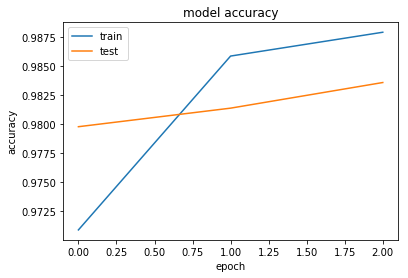

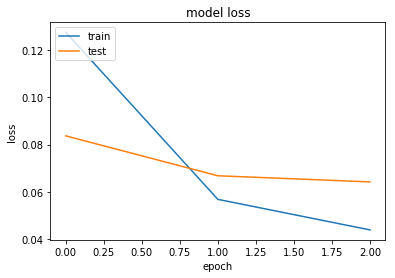

In [281]:
print(history.history.keys())

# summarizing history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarizing history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

__Testing on the test dataset__

In [9]:
# reading in testing data
# creating a pandas dataframe to store features before feeding into the classifier
# the dataset does not have a label

data = pd.DataFrame(columns=['message', 'word', 'label'])
i = 1
file = open("test.txt", "r")
for x in file:
    tmp_list = x[:-1].split("\t")
    try:
        tmp_dict = {'message': i,'word': tmp_list[0], 'label': ''}
        if tmp_list[0] == '':
            i = i+1
        else:
            data = data.append(tmp_dict, ignore_index=True)
            #print(tmp_dict)
    except:
        i = i+1

In [283]:
print(data.head(10))
print("\nnumber of rows in the testing dataframe:", len(data))

  message     word label
0       1        &      
1       1       gt      
2       1        ;      
3       1        *      
4       1      The      
5       1  soldier      
6       1      was      
7       1   killed      
8       1     when      
9       1  another      

number of rows in the testing dataframe: 23394


In [284]:
test_obj = Message(data)
test_messages = test_obj.messages
x_test = pad_messages(test_messages)

In [285]:
x_test = x_test[:int(len(x_test)/32)*batch_size]
x_test = np.array(x_test)
test_pred = model.predict(np.array(x_test), verbose=1)

1280/1280 [==============================] - 199s 155ms/step


In [286]:
encoder = {i: w for w, i in encoded_labels.items()}

def predict_label(pred):
    pred_labels = []
    for pred_i in pred:
        label_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            label_i.append(encoder[p_i].replace("padding", "O"))
        pred_labels.append(label_i)
    return pred_labels
    
pred_labels = predict_label(test_pred)

In [287]:
# lets look at some of the predictions on test data
results = []
for i in range(len(pred_labels)):
    for j in range(len(pred_labels[0])):
        if x_test[i][j] != 'padding':
            results.append((x_test[i][j], pred_labels[i][j]))
results[:30]

('&', 'O')
('gt', 'O')
(';', 'O')
('*', 'O')
('The', 'O')
('soldier', 'O')
('was', 'O')
('killed', 'O')
('when', 'O')
('another', 'O')
('avalanche', 'O')
('hit', 'O')
('an', 'O')
('army', 'O')
('barracks', 'O')
('in', 'O')
('the', 'O')
('northern', 'O')
('area', 'O')
('of', 'O')
('Sonmarg', 'B-location')
(',', 'O')
('said', 'O')
('a', 'O')
('military', 'O')
('spokesman', 'O')
('.', 'O')
('&', 'O')
('gt', 'O')
(';', 'O')
('*', 'O')
('Police', 'O')
('last', 'O')
('week', 'O')
('evacuated', 'O')
('80', 'O')
('villagers', 'O')
('from', 'O')
('Waltengoo', 'B-location')
('Nar', 'I-location')
('where', 'O')
('dozens', 'O')
('were', 'O')
('killed', 'O')
('after', 'O')
('a', 'O')
('series', 'O')
('of', 'O')
('avalanches', 'O')
('hit', 'O')
('the', 'O')
('area', 'O')
('in', 'O')
('2005', 'O')
('in', 'O')
('the', 'O')
('south', 'O')
('of', 'O')
('the', 'O')
('territory', 'O')
('.', 'O')
('&', 'O')
('gt', 'O')
(';', 'O')
('*', 'O')
('The', 'O')
('army', 'O')
('on', 'O')
('Thursday', 'O')
('recover

('in', 'O')
('2016', 'O')
('.', 'O')
('Was', 'O')
('on', 'O')
('the', 'O')
('DSP', 'O')
('and', 'O')
('found', 'O')
('his', 'O')
('/', 'O')
('her', 'O')
('way', 'O')
('back', 'O')
('to', 'O')
('a', 'O')
('normal', 'O')
('life', 'O')
('with', 'O')
('his', 'O')
('/', 'O')
('her', 'O')
('own', 'O')
('income', 'O')
('.', 'O')
('*', 'O')
('*', 'O')
('submission', 'O')
('title', 'O')
('*', 'O')
('*', 'O')
(':', 'O')
('Proposed', 'O')
('class', 'O')
('action', 'O')
('against', 'O')
('B', 'O')
('.', 'O')
('C', 'O')
('.', 'O')
('[', 'O')
('Source', 'O')
(']', 'O')
('(', 'O')
('https://www.reddit.com/r/southafrica/comments/5sdwm2/breaking_joost_van_der_westhuizen_dies/', 'O')
(')', 'O')
('at', 'O')
('/', 'O')
('r', 'O')
('/', 'O')
('southafrica', 'O')
('The', 'O')
('idea', 'O')
('that', 'O')
('one', 'O')
('IRA', 'O')
('was', 'O')
('kinder', 'O')
('or', 'O')
('more', 'O')
('moral', 'O')
('than', 'O')
('the', 'O')
('other', 'O')
('is', 'O')
('ludicrous', 'O')
('.', 'O')
('I', 'O')
('hear', 'O')
('

('rub', 'O')
('off', 'O')
('on', 'O')
('the', 'O')
('entitled', 'O')
('prick', 'O')
('.', 'O')
('There', 'O')
('is', 'O')
('[', 'O')
('literally', 'O')
('a', 'O')
('Mises', 'O')
('quote', 'O')
(']', 'O')
('(', 'O')
('https://www.reddit.com/r/canada/comments/5ojc65/vanguard_says_bank_of_canada_will_hike_rates_this/dckhgn5/', 'O')
(')', 'O')
('in', 'O')
('the', 'O')
('thread', 'O')
('.', 'O')
('Is', 'O')
('doch', 'O')
('eh', 'O')
('nur', 'O')
('heiße', 'O')
('Luft', 'O')
('.', 'O')
('@', 'O')
('Maronti', 'O')
('Hi', 'O')
('.', 'O')
('FYI', 'O')
('about', 'O')
('a', 'O')
('month', 'O')
('ago', 'O')
('there', 'O')
('was', 'O')
('a', 'O')
('post', 'O')
('about', 'O')
('general', 'O')
('info', 'O')
('on', 'O')
('protection', 'O')
('orders', 'O')
(':', 'O')
('[', 'O')
('Live', 'O')
('Goal', 'O')
('+', 'O')
('Replays', 'O')
('-', 'O')
('AA', 'O')
('Mirror', 'O')
('HD', 'O')
(']', 'O')
('(', 'O')
('https://streamable.com/qlwoq', 'O')
(')', 'O')
('[', 'O')
('AA', 'O')
('Mirror', 'O')
('Replays',

('.', 'O')
('Hi', 'O')
('there', 'O')
('/', 'O')
('u', 'O')
('/', 'O')
('Mo-bot', 'O')
(',', 'O')
('the', 'O')
('actual', 'O')
('AMA', 'O')
('[', 'O')
('can', 'O')
('be', 'O')
('found', 'O')
('here', 'O')
(']', 'O')
('(', 'O')
('https://www.reddit.com/r/newzealand/comments/5q10gc/ask_me_anything_act_leader_david_seymour/', 'O')
(')', 'O')
('.', 'O')
('AMA', 'O')
('with', 'O')
('the', 'O')
('leader', 'O')
('of', 'O')
('the', 'O')
('Conservative', 'O')
('Party', 'O')
('.', 'O')
('[', 'O')
('Live', 'O')
('in', 'O')
('Dalhousie', 'B-location')
(']', 'O')
('(', 'O')
('https://www.reddit.com/r/Calgary/comments/5lg5bb/snow_angels/', 'O')
(')', 'O')
('?', 'O')
('I', 'O')
('was', 'O')
('just', 'O')
('looking', 'O')
('at', 'O')
('the', 'O')
('wayback', 'O')
('machine', 'O')
('on', 'O')
('/', 'O')
('r', 'O')
('/', 'O')
('politics', 'O')
(':', 'O')
('here', 'O')
("'", 'O')
('s', 'O')
('the', 'O')
('front', 'O')
('page', 'O')
('for', 'O')
('September', 'O')
('on', 'O')
('/', 'O')
('r', 'O')
('/', '

('/', 'O')
('TruFalcon', 'O')
('.', 'O')
('&', 'O')
('gt', 'O')
(';', 'O')
('Are', 'O')
('you', 'O')
('hoping', 'O')
('that', 'O')
('someone', 'O')
('in', 'O')
('R', 'O')
('/', 'O')
('Calgary', 'B-location')
('just', 'O')
('happens', 'O')
('to', 'O')
('be', 'O')
('a', 'O')
('stock', 'O')
('shelfer', 'O')
('there', 'O')
('or', 'O')
('has', 'O')
('an', 'O')
('extremely', 'O')
('intimate', 'O')
('knowledge', 'O')
('of', 'O')
('all', 'O')
('of', 'O')
('their', 'O')
('1', 'O')
('million', 'O')
('items', 'O')
('?', 'O')
('I', 'O')
('am', 'O')
('not', 'O')
('a', 'O')
('huge', 'O')
('supporter', 'O')
('of', 'O')
('Corbyn', 'B-person')
(',', 'O')
('ive', 'O')
('been', 'O')
('rather', 'O')
('critical', 'O')
('of', 'O')
('a', 'O')
('lot', 'O')
('of', 'O')
('his', 'O')
('moves', 'O')
('recently', 'O')
('but', 'O')
('I', 'O')
('like', 'O')
('the', 'O')
('idea', 'O')
('of', 'O')
('a', 'O')
('lot', 'O')
('of', 'O')
('his', 'O')
('policies', 'O')
('.', 'O')
('Of', 'O')
('course', 'O')
('there', 'O')
(

('Steeven', 'B-person')
('added', 'O')
('a', 'O')
('sketch', 'O')
('.', 'O')
('Physical', 'O')
('chemistry', 'O')
('problem', 'O')
('This', 'O')
('answer', 'O')
('seems', 'O')
('speculative', 'O')
(',', 'O')
('more', 'O')
('of', 'O')
('an', 'O')
('opinion', 'O')
('piece', 'O')
(';', 'O')
('but', 'O')
('the', 'O')
('OP', 'O')
('is', 'O')
('requesting', 'O')
('fact', 'O')
('checking', 'O')
('.', 'O')
('Supposing', 'O')
('at', 'O')
('present', 'O')
('the', 'O')
('facts', 'O')
('are', 'O')
('obscured', 'O')
('by', 'O')
('mystery', 'O')
(',', 'O')
('there', 'O')
("'", 'O')
('s', 'O')
('no', 'O')
('harm', 'O')
('in', 'O')
('leaving', 'O')
('it', 'O')
('unanswered', 'O')
('.', 'O')
('[', 'O')
('The', 'O')
('version', 'O')
('found', 'O')
('in', 'O')
('the', 'O')
('CoS', 'O')
('game', 'O')
(']', 'O')
('(', 'O')
('http://i.imgur.com/LhhRTyG.jpg', 'O')
(')', 'O')
('(', 'O')
('which', 'O')
('has', 'O')
('been', 'O')
('[', 'O')
('confirmed', 'O')
('to', 'O')
('be', 'O')
('written', 'O')
('by', 'O')

('not', 'O')
('what', 'O')
('you', 'O')
('asked', 'O')
('about', 'O')
('in', 'O')
('your', 'O')
('question', 'O')
(',', 'O')
('which', 'O')
('is', 'O')
('why', 'O')
('my', 'O')
('answer', 'O')
('discusses', 'O')
('a', 'O')
('different', 'O')
('type', 'O')
('of', 'O')
('symmetry', 'O')
('breaking', 'O')
('.', 'O')
('But', 'O')
('your', 'O')
('comment', 'O')
('here', 'O')
('certainly', 'O')
('implies', 'O')
('a', 'O')
('fair', 'O')
('They', 'O')
('also', 'O')
('used', 'O')
("'", 'O')
('magic', 'O')
("'", 'O')
('to', 'O')
('accomplish', 'O')
('their', 'O')
('works', 'O')
('.', 'O')
('Minas', 'O')
('Tirith', 'O')
('(', 'O')
('The', 'O')
('First', 'O')
('Age', 'O')
('one', 'O')
(')', 'O')
('had', 'O')
('a', 'O')
('spell', 'O')
('bounding', 'O')
('stone', 'O')
('to', 'O')
('stone', 'O')
(',', 'O')
('and', 'O')
('it', 'O')
('collapsed', 'O')
('after', 'O')
('Lúthien', 'O')
('had', 'O')
('broken', 'O')
('it', 'O')
('.', 'O')
('Visualizing', 'O')
('the', 'O')
('$', 'O')
('H', 'O')
('$', 'O')
('

('account', 'O')
('of', 'O')
('the', 'O')
('current', 'O')
('President', 'O')
("'", 'O')
('s', 'O')
('monetary', 'O')
('debts', 'O')
('?', 'O')
('How', 'O')
('did', 'O')
('the', 'O')
('doctor', 'O')
('know', 'O')
('the', 'O')
('cause', 'O')
('of', 'O')
('death', 'O')
('just', 'O')
('by', 'O')
('putting', 'O')
('his', 'O')
('ear', 'O')
('on', 'O')
('the', 'O')
('dead', 'O')
('body', 'O')
('?', 'O')
('@', 'O')
('Valorum', 'O')
(':', 'O')
('Do', 'O')
('you', 'O')
('want', 'O')
('to', 'O')
('grab', 'O')
('any', 'O')
('or', 'O')
('all', 'O')
('of', 'O')
('my', 'O')
('memory', 'O')
('erasure', 'O')
('bit', 'O')
('?', 'O')
('Why', 'O')
('do', 'O')
('all', 'O')
('Potterwatch', 'O')
('contributors', 'O')
("'", 'O')
('codenames', 'O')
('start', 'O')
('with', 'O')
('"', 'O')
('R', 'O')
('"', 'O')
('?', 'O')
('Buffer', 'O')
('overflow', 'O')
('attack', 'O')
('Why', 'O')
('was', 'O')
('Hogwarts', 'O')
('so', 'O')
('adamant', 'O')
('about', 'O')
('having', 'O')
('Harry', 'B-person')
('go', 'O')
('th

('a', 'O')
('picture', 'O')
('from', 'O')
('the', 'O')
('actual', 'O')
('show', 'O')
('?', 'O')
('.', 'O')
('.', 'O')
('.', 'O')
('Er', 'O')
(',', 'O')
('did', 'O')
('n', 'O')
("'", 'O')
('t', 'O')
('it', 'O')
('say', 'O')
('on', 'O')
('the', 'O')
('page', 'O')
('where', 'O')
('it', 'O')
('was', 'O')
('from', 'O')
('?', 'O')
('Looking', 'O')
('for', 'O')
('a', 'O')
('movie', 'O')
('where', 'O')
('there', 'O')
('is', 'O')
('a', 'O')
('Powerful', 'O')
('Board', 'O')
('Game', 'O')
('played', 'O')
('by', 'O')
('two', 'O')
('brothers', 'O')
('?', 'O')
('my', 'O')
('concern', 'O')
('is', 'O')
('about', 'O')
('securing', 'O')
('the', 'O')
('content', 'O')
('of', 'O')
('the', 'O')
('output', 'O')
('of', 'O')
('the', 'O')
('api', 'O')
('.', 'O')
('.', 'O')
('request', 'O')
('to', 'O')
('read', 'O')
('the', 'O')
('question', 'O')
('and', 'O')
('the', 'O')
('details', 'O')
('again', 'O')
('Please', 'O')
('keep', 'O')
('it', 'O')
('classy', 'O')
('I', 'O')
("'", 'O')
('m', 'O')
('voting', 'O')
('t

('firewall', 'O')
('/', 'O')
('closed', 'O')
('ports', 'O')
('requires', 'O')
('proxy', 'O')
('How', 'O')
('can', 'O')
('a', 'O')
('country', 'O')
('(', 'O')
('UN', 'O')
('or', 'O')
('non-', 'O')
('UN', 'O')
('member', 'O')
(')', 'O')
('become', 'O')
('a', 'O')
('member', 'O')
('of', 'O')
('World', 'O')
('Bank', 'O')
('?', 'O')
('Javier', 'O')
('.', 'O')
('.', 'O')
('So', 'O')
('the', 'O')
('net', 'O')
('force', 'O')
('remains', 'O')
('but', 'O')
('now', 'O')
('involves', 'O')
('my', 'O')
('hands', 'O')
('as', 'O')
('well', 'O')
('.', 'O')
('That', 'O')
('makes', 'O')
('sense', 'O')
('!', 'O')
('oo', 'O')
('What', 'O')
('building', 'O')
('in', 'O')
('the', 'O')
('final', 'O')
('scene', 'O')
('of', 'O')
('Assassins', 'B-creative-work')
('Creed', 'I-creative-work')
('?', 'O')
('(', 'O')
('spoiler', 'O')
(')', 'O')
('Probably', 'O')
('its', 'O')
('the', 'O')
('second', 'O')
('time', 'O')
('coming', 'O')
('back', 'O')
('from', 'O')
('the', 'O')
('dead', 'O')
(',', 'O')
('not', 'O')
('just'

('of', 'O')
('photon', 'O')
('and', 'O')
('frequency', 'O')
('of', 'O')
('EM', 'O')
('wave', 'O')
('Potential', 'O')
('HTTP', 'O')
('Host', 'O')
('header', 'O')
('attack', 'O')
('from', 'O')
('malicious', 'O')
('IP', 'O')
(',', 'O')
('what', 'O')
('does', 'O')
('it', 'O')
('mean', 'O')
('in', 'O')
('practical', 'O')
('terms', 'O')
('for', 'O')
('me', 'O')
('?', 'O')
('Should', 'O')
('I', 'O')
('be', 'O')
('concerned', 'O')
('?', 'O')
('Was', 'O')
('this', 'O')
('a', 'O')
('typo', 'O')
('from', 'O')
('the', 'O')
('table', 'O')
('maker', 'O')
(',', 'O')
('or', 'O')
('are', 'O')
('other', 'O')
('criteria', 'O')
('taken', 'O')
('into', 'O')
('account', 'O')
('when', 'O')
('calculating', 'O')
('the', 'O')
('overall', 'O')
('score', 'O')
('?', 'O')
('He', 'O')
("'", 'O')
('s', 'O')
('also', 'O')
('coincidentally', 'O')
('the', 'O')
('very', 'O')
('first', 'O')
('example', 'O')
('on', 'O')
('the', 'O')
('page', 'O')
('about', 'O')
('[', 'O')
('geniuses', 'O')
(']', 'O')
('(', 'O')
('http://ma

('I', 'O')
("'", 'O')
('m', 'O')
('trying', 'O')
('to', 'O')
('!', 'O')
('https://t.co/EpyCB6rhmq', 'O')
('@', 'O')
('rootstroye', 'O')
('oh', 'O')
('omg', 'O')
('i', 'O')
('forgot', 'O')
('you', 'O')
('don', 'O')
("'", 'O')
('t', 'O')
('live', 'O')
('in', 'O')
('toronto', 'O')
('oOPS', 'O')
('RT', 'O')
('@', 'O')
('elessar', 'O')
('42', 'O')
(':', 'O')
('Psst', 'O')
('.', 'O')
('Trump', 'B-person')
('saying', 'O')
('that', 'O')
('millions', 'O')
('voted', 'O')
('illegally', 'O')
('is', 'O')
('pretext', 'O')
('to', 'O')
('destroy', 'O')
('voting', 'O')
('rights', 'O')
('.', 'O')
('Don', 'O')
("'", 'O')
('t', 'O')
('treat', 'O')
('it', 'O')
('like', 'O')
('some', 'O')
('random', 'O')
('quirk', 'O')
('.', 'O')
('@', 'O')
('Bulls', 'B-group')
('_', 'O')
('Jay', 'B-person')
('I', 'O')
("'", 'O')
('d', 'O')
('like', 'O')
('to', 'O')
('think', 'O')
('their', 'O')
('mess', 'O')
('levels', 'O')
('are', 'O')
('on', 'O')
('par', 'O')
('Making', 'O')
('my', 'O')
('base', 'O')
('secure', 'O')
(':'

('spanishcvndy', 'O')
(':', 'O')
('If', 'O')
('we', 'O')
('can', 'O')
("'", 'O')
('t', 'O')
('raise', 'O')
('a', 'O')
('dog', 'O')
('together', 'O')
(',', 'O')
('then', 'O')
('we', 'O')
('not', 'O')
('meant', 'O')
('to', 'O')
('be', 'O')
('together', 'O')
('https://t.co/oKc66awesp', 'O')
('#', 'O')
('mature', 'O')
('group', 'O')
('sex', 'O')
('clips', 'O')
('fucking', 'O')
('black', 'O')
('babe', 'O')
('https://t.co/WS4mEwtgnw', 'O')
('RT', 'O')
('@', 'O')
('TheLeadCNN', 'O')
(':', 'O')
('.', 'O')
('@', 'O')
('jaketapper', 'O')
(':', 'O')
('There', 'O')
('is', 'O')
('a', 'O')
('reason', 'O')
('White', 'O')
('House', 'O')
('is', 'O')
('providing', 'O')
('no', 'O')
('evidence', 'O')
('about', 'O')
('voter', 'O')
('fraud', 'O')
('claim', 'O')
('–', 'O')
('there', 'O')
('is', 'O')
('no', 'O')
('evidence', 'O')
('…', 'O')
('Leaves', 'O')
('!', 'O')
('https://t.co/RaRNJ6cu9a', 'O')
('RT', 'O')
('@', 'O')
('nochillthalia', 'O')
(':', 'O')
('1', 'O')
('.', 'O')
('so', 'O')
('lets', 'O')
('star

('goal', 'O')
('.', 'O')
('https://t.co/OomsNdQocf', 'O')
('@', 'O')
('kimischilling', 'O')
('there', 'O')
("'", 'O')
('s', 'O')
('always', 'O')
('something', 'O')
('https://t.co/rNGTYQSDUY', 'O')
('Student', 'O')
('Guest', 'O')
('Program', 'O')
('#', 'O')
('Bothell', 'O')
('https://t.co/BrqvFFslAz', 'O')
('I', 'O')
('see', 'O')
('why', 'O')
('its', 'O')
('rope', 'O')
('gang', 'O')
('now', 'O')
('😂', 'O')
('big', 'O')
('dick', 'O')
('clique', 'O')
('@', 'O')
('onsomeshit', 'O')
('@', 'O')
('usedgov', 'O')
('Do', 'O')
('it', 'O')
('while', 'O')
('you', 'O')
('can', 'O')
('!', 'O')
('Who', 'O')
('knows', 'O')
('what', 'O')
('will', 'O')
('happen', 'O')
('in', 'O')
('the', 'O')
('coming', 'O')
('year', 'O')
('(', 'O')
('s', 'O')
(')', 'O')
('.', 'O')
('😒', 'O')
('😔', 'O')
('@', 'O')
('TwoBlindBros', 'O')
('Fantastic', 'O')
('piece', 'O')
('on', 'O')
('@', 'O')
('NBCNightlyNews', 'O')
('tonight', 'O')
('!', 'O')
('!', 'O')
('!', 'O')
('Love', 'O')
('you', 'O')
('guys', 'O')
('!', 'O')
('!'

('I', 'O')
("'", 'O')
('d', 'O')
('rather', 'O')
('have', 'O')
('Dory', 'B-person')
('.', 'O')
('https://t.co…', 'O')
('Pretty', 'O')
('much', 'O')
('https://t.co/XJedTummZz', 'O')
('RT', 'O')
('@', 'O')
('broken', 'O')
(':', 'O')
('how', 'O')
('to', 'O')
('trust', 'O')
('someone', 'O')
(':', 'O')
('you', 'O')
('don', 'O')
("'", 'O')
('t', 'O')
('Want', 'O')
('to', 'O')
('pretend', 'O')
('you', 'O')
('’', 'O')
('re', 'O')
('performing', 'O')
('in', 'O')
('front', 'O')
('of', 'O')
('10', 'O')
(',', 'O')
('000', 'O')
('people', 'O')
('?', 'O')
('Then', 'O')
('decide', 'O')
('#', 'O')
('whatshouldplaynext', 'O')
('on', 'O')
('Power', 'O')
('95', 'O')
('.', 'O')
('3', 'O')
('https://t.co/ojpWdx1gIT', 'O')
('"', 'O')
('When', 'O')
('you', 'O')
('understand', 'O')
('that', 'O')
('life', 'O')
('is', 'O')
('a', 'O')
('test', 'O')
(',', 'O')
('you', 'O')
('realize', 'O')
('that', 'O')
('nothing', 'O')
('is', 'O')
('insignificant', 'O')
('in', 'O')
('your', 'O')
('life', 'O')
('.', 'O')
('"', 'O

('ITV', 'O')
('could', 'O')
('arrange', 'O')
('for', 'O')
('you', 'O')
('and', 'O')
('@', 'O')
('hollywills', 'O')
('to', 'O')
('film', 'O')
('the', 'O')
('Wha', 'O')
('wha', 'O')
('tribe', 'O')
('.', 'O')
('I', 'O')
("'", 'O')
('d', 'O')
('watch', 'O')
('that', 'O')
('sooo', 'O')
('funny', 'O')
('😂', 'O')
('@', 'O')
('KammBe', 'O')
('thats', 'O')
('no', 'O')
('help', 'O')
('@', 'O')
('TonyTGoodman', 'O')
('@', 'O')
('WholeFoods', 'O')
('@', 'O')
('NorahRab', 'O')
('We', 'O')
('just', 'O')
('missed', 'O')
('you', 'O')
('!', 'O')
('Tonight', 'O')
('at', 'O')
('10', 'O')
('on', 'O')
('KODE', 'O')
('Action', 'O')
('12', 'O')
('News', 'O')
('.', 'O')
('#', 'O')
('kode', 'O')
('12', 'O')
('https://t.co/Ad6ruIyr5M', 'O')
('Help', 'O')
('to', 'O')
('Stop', 'O')
('Cruel', 'O')
('Treatment', 'O')
('of', 'O')
('Monkeys', 'O')
('at', 'O')
('Biomedical', 'B-location')
('Laboratories', 'O')
('!', 'O')
('Plz', 'O')
('sign', 'O')
(':', 'O')
('https://t.co/c55GE1ecfz', 'O')
('https://t.co/d7TyB0bIbm',

('I', 'O')
('got', 'O')
('rear', 'O')
('ended', 'O')
('today', 'O')
('.', 'O')
('Luckily', 'O')
(',', 'O')
('this', 'O')
('is', 'O')
('all', 'O')
('the', 'O')
('work', 'O')
('my', 'O')
('car', 'O')
('needed', 'O')
('.', 'O')
('https://t.co/4BEOtmooo9', 'O')
('teen', 'O')
('wolf', 'O')
('sai', 'O')
('logo', 'O')
('do', 'O')
('hiatus', 'O')
('eu', 'O')
('te', 'O')
('imploroo', 'O')
('RT', 'O')
('@', 'O')
('themovingroad', 'O')
(':', 'O')
('Do', 'O')
('all', 'O')
('things', 'O')
('with', 'O')
('love', 'O')
('.', 'O')
('Og', 'O')
('Mandino', 'O')
('#', 'O')
('quote', 'O')
('#', 'O')
('groovy', 'O')
('hot', 'O')
('sex', 'O')
('videos', 'O')
('brutal', 'O')
('interracial', 'O')
('sex', 'O')
('https://t.co/svhiOkac2D', 'O')
('RT', 'O')
('@', 'O')
('BeautyOfAnAries', 'O')
(':', 'O')
('ARIES', 'O')
('.', 'O')
('.', 'O')
('.', 'O')
('.', 'O')
('.', 'O')
('.', 'O')
('.', 'O')
('.', 'O')
('our', 'O')
('season', 'O')
('starts', 'O')
('in', 'O')
('4', 'O')
('days', 'O')
('😈', 'O')
('@', 'O')
('Junio

('i', 'O')
('was', 'O')
('in', 'O')
('boy', 'O')
('scouts', 'O')
('i', 'O')
('know', 'O')
('what', 'O')
('im', 'O')
('doing', 'O')
('!', 'O')
('"', 'O')
('-', 'O')
('he', 'O')
('dont', 'O')
('know', 'O')
('what', 'O')
('he', 'O')
('doing', 'O')
('-', 'O')
('already', 'O')
('started', 'O')
('growing', 'O')
('weed', 'O')
('-', 'O')
('s', 'O')
('…', 'O')
('RT', 'O')
('@', 'O')
('WhoadieBrees', 'O')
(':', 'O')
('Tatum', 'B-person')
('really', 'O')
('Prime', 'O')
('Melo', 'O')
('in', 'O')
('the', 'O')
('iso', 'O')
('RT', 'O')
('@', 'O')
('FemaleKnows', 'O')
(':', 'O')
('@', 'O')
('anyone', 'O')
('who', 'O')
("'", 'O')
('s', 'O')
('ever', 'O')
('tried', 'O')
('to', 'O')
('dm', 'O')
('or', 'O')
('text', 'O')
('me', 'O')
('https://t.co/0zI1d5mxfG', 'O')
('RT', 'O')
('@', 'O')
('jackiedomingez', 'O')
(':', 'O')
('the', 'O')
('loml', 'O')
('picked', 'O')
('this', 'O')
('https://t.co/jPBeiJnDip', 'O')
('@', 'O')
('Hugo', 'O')
('_', 'O')
('_', 'O')
('_', 'O')
('_', 'O')
('Hugo', 'O')
('check', 'O'

- The model is good at recognizing `B/I-person`, `b/I-location` and `B/I-corporation` over `B/I-creative work`. I suppose this is because creative-work had a slighly more abstract definition compared to other classes.

- The model seems to accurately tag `B-` and `I-` prefixes, For example, 'Smith Tower' is tagged as `'B-location'` and `'I-location'`, respectively. Although 'Smith' could've been a `B-person`, the model was able to add context to this word by looking at the succeeding word to classify both as `'-location'`.

- There are, however, some examples where this is not true. For example, 'Dark' in 'Dark Night' is tagged as `'B-creative-work'`, leaving out the tagging for 'Night'.

- Some of the testing data was cut out since the maximum length after padding all messages was taken as 41 (as this was what the model was trained on). The maximum message length in the testing data is 105. This model could be improved by ensuring none of the testing data is left out. 

- Some false positivies. For example, 'Swift' is tagged as `B-person` although it refers to its adjective form here.

- Also, there are some words which aren't being recognized and are tagged 'O' instead of their actual classes. For example 'DRDO', 'Mahazgund' etc.

Nevertheless, this model outperforms the first two models and there is definety room for improvement as this was merely the first few attempts. One way to do this would be to perform hyperparameter optimization to find model settings better suited for this use case. I would also consider looking at bidirectional LSTM literature models used for NER applications to tweak or augment the exisitng model.